# Interpretable Recurrent Neural Network Video MNIST Demo

Dataset courtesty of github user [despoisj](https://github.com/despoisj) and his/her [LatentSpaceVisualization]( https://github.com/despoisj/LatentSpaceVisualization) project.

---

# Load Data and Visualize

4


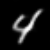

4


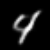

4


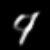

7


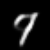

7


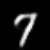

7


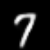

7


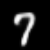

7


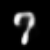

7


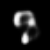

5


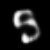

In [29]:
from IPython.display import display
import pickle

[imgs, y] = pickle.load(open('LatentSpaceVisualization/Visuals/mnist_transitions.p', 'rb'))
for img, y_ in zip(imgs[:10], y[:10]):
    print(y_)
    display(img)

# Interactive Visualization

In [30]:
from ipywidgets import interact, fixed
import ipywidgets as widgets

@interact(imgs=fixed(imgs), y=fixed(y), i=widgets.IntSlider(min=0, max=len(y), step=1))
def mnist_video(imgs, y, i):
    print(y[i])
    return imgs[i].resize(size=[128, 128])

# Transitions

In [10]:
import numpy as np
import pandas as pd
import seaborn.apionly as sns

T = np.zeros([10, 10])
for d_now, d_next in zip(y, y[1:]):
    T[int(d_now), int(d_next)] += 1
    
pd.DataFrame(T).style\
.set_caption('Transition Counts Between Digit Classes')\
.background_gradient(cmap=sns.diverging_palette(250, 5, as_cmap=True))

# Digit Prevalence

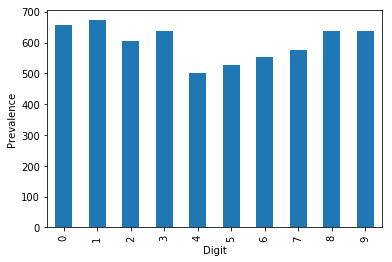

In [11]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

axes = pd.Series(Counter(y)).plot(kind='bar')
axes.set_xlabel('Digit');
axes.set_ylabel('Prevalence');

# Flatten Images

In [12]:
import numpy as np
from keras.preprocessing.image import img_to_array, array_to_img
from keras.utils.np_utils import to_categorical

imgs = [img.resize(size=[28, 28]) for img in imgs]
X = np.array([img_to_array(img).flatten() for img in imgs]) / 255.
Y = to_categorical(y)

X.shape, Y.shape

((6000, 784), (6000, 10))

# Build Multi-Class Logistic Regression Classifier

In [13]:
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
%matplotlib inline

model = Sequential()
model.add(Dense(units=10, activation='softmax', input_shape=[784]))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                7850      
Total params: 7,850.0
Trainable params: 7,850
Non-trainable params: 0.0
_________________________________________________________________


# Fit the Multi-Class Logistic Regression Classifier

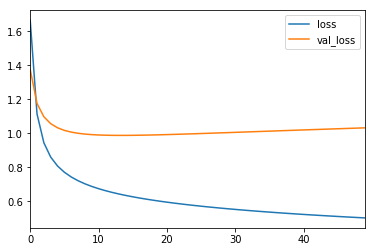

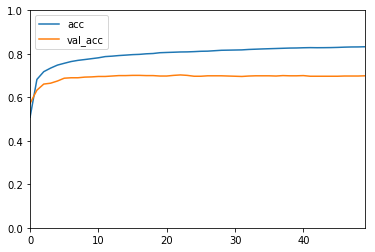

5000/5000 [==============================] - 0s - loss: 0.5027 - acc: 0.8326 - val_loss: 1.0321 - val_acc: 0.6990


In [14]:
import IPython
import keras
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

class TrainingVisualizer(keras.callbacks.History):
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)
        IPython.display.clear_output(wait=True)
        pd.DataFrame({key: value for key, value in self.history.items() if key.endswith('loss')}).plot()
        axes = pd.DataFrame({key: value for key, value in self.history.items() if key.endswith('acc')}).plot()
        axes.set_ylim([0, 1])
        plt.show()

model.fit(X[:-1000], Y[:-1000],
          validation_data=(X[-1000:], Y[-1000:]),
          shuffle=False,
          epochs=50,
          callbacks=[TrainingVisualizer()]);

# Weights $W$ and $b$

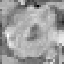

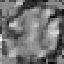

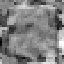

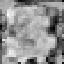

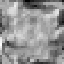

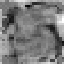

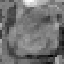

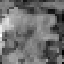

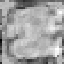

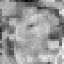

In [15]:
W, b = model.layers[0].get_weights()

for i in range(10):
    w = W[:, i].reshape(28, 28, 1)
    img = array_to_img(w).resize(size=[64, 64])
    display(img)

# Confusion Matrix

In [16]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y[-1000:].astype(np.uint), model.predict_classes(X[-1000:]))

pd.DataFrame(cm).style\
.set_caption('Confusion Matrix for Multi-Class Logistic Regression Classifier')\
.background_gradient(cmap=sns.diverging_palette(250, 5, as_cmap=True))

  32/1000 [..............................] - ETA: 0s

# Interactive Demo

In [17]:
from keras.preprocessing.image import array_to_img

def prediction_generator(X, Y):
    for i, (x, y) in enumerate(zip(X, Y.argmax(axis=1))):
        print(y)
        x_ = x.reshape(28, 28, 1)
        img = array_to_img(x_)
        display(img)
        pred = model.predict(np.expand_dims(x, axis=0))[0]
        axes = pd.Series(pred).plot(kind='bar')
        axes.set_ylim([0, 1])
        plt.show()
        yield

prediction = prediction_generator(X[-1000:], Y[-1000:])

7


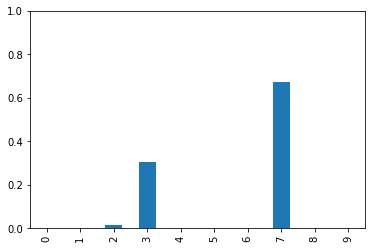

In [18]:
next(prediction)

# Stagger Subsequences to use with keras Stateful RNNs

In [19]:
def make_staggered(X_partition, Y_partition, timesteps):
    nb_start = len(Y_partition[0]) // timesteps # number of starts a sequence gets per epoch
    nb_sequence = len(Y_partition) # number of independent sequences
    
    X = np.zeros([nb_start*nb_sequence, timesteps, 784])
    Y = np.zeros([nb_start*nb_sequence, timesteps, 10])
    for i, (x, y) in enumerate(zip(X_partition, Y_partition)):
        X[i::nb_sequence] = x.reshape(nb_start, timesteps, 784)
        Y[i::nb_sequence] = y.reshape(nb_start, timesteps, 10)
        
    return X, Y

# Non-Overlapping Subsequences

In [20]:
batch_size = 100
timesteps = 10

X_partition, Y_partition = np.split(X[:-1000], batch_size), np.split(Y[:-1000], batch_size)
X_partition_val, Y_partition_val = np.split(X[-1000:], batch_size), np.split(Y[-1000:], batch_size)

XX, YY = make_staggered(X_partition, Y_partition, timesteps)
XX_val, YY_val = make_staggered(X_partition_val, Y_partition_val, timesteps)

# Overlapping Subsequences

Optional! Don't execute unless you want this option.

In [ ]:
batch_size = 100
timesteps = 10

trim = (6000//batch_size) // 2
X_partition = np.split(X, batch_size) + np.split(X[trim:-trim], batch_size-1)
Y_partition = np.split(Y, batch_size) + np.split(Y[trim:-trim], batch_size-1)

XX, YY = make_staggered(X_partition, Y_partition, timesteps)
batch_size = 2*batch_size - 1

# Define Recurrent Model

In [21]:
from keras.models import Sequential
from keras.layers import SimpleRNN, TimeDistributed, Dense

model = Sequential()
model.add(SimpleRNN(units=10, activation='softmax', return_sequences=True, batch_input_shape=[batch_size, timesteps, 784]))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (100, 10, 10)             7950      
Total params: 7,950.0
Trainable params: 7,950
Non-trainable params: 0.0
_________________________________________________________________


# Fit RNN Model

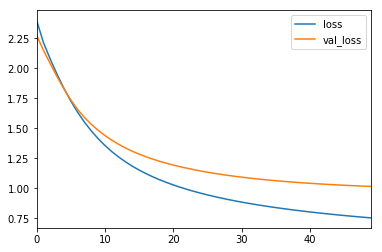

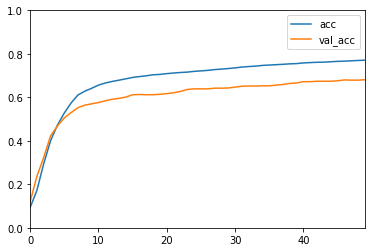

500/500 [==============================] - 0s - loss: 0.7537 - acc: 0.7708 - val_loss: 1.0156 - val_acc: 0.6810


In [22]:
import keras

class ResetStates(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        self.model.reset_states()

model.fit(XX, YY, batch_size,
          validation_data=(XX_val, YY_val),
          shuffle=False,
          epochs=50,
          callbacks=[ResetStates(), TrainingVisualizer()]);

# Confusion Matrix

In [16]:
from sklearn.metrics import confusion_matrix

model.reset_states()
a = np.arange(batch_size)
preds = []
for i in range(100):
    XX_rolled = XX_val[a]
    pred = model.predict_classes(XX_rolled, batch_size, verbose=0)[0]
    preds.append(pred)
    a = np.roll(a, shift=-1)

cm = confusion_matrix(y[-1000:].astype(np.uint), np.hstack(preds))

pd.DataFrame(cm).style\
.set_caption('Confusion Matrix for Recurrent Neural Network Classifier')\
.background_gradient(cmap=sns.diverging_palette(250, 5, as_cmap=True))

# Visualize RNN Predictions

In [23]:
from keras.preprocessing.image import array_to_img

def prediction_generator(X, Y, batch_size, timesteps):
    model.reset_states()
    a = np.arange(batch_size)
    for i in range(batch_size):
        X_rolled = X[a]
        preds = model.predict(X_rolled, batch_size)[0]
        x, y = X_rolled[0], Y[i].argmax(axis=1)
        for j in range(timesteps):
            print(y[j])
            x_ = x[j].reshape(28, 28, 1)
            img = array_to_img(x_)
            display(img)
            pred = preds[j]
            axes = pd.Series(pred).plot(kind='bar')
            axes.set_ylim([0, 1])
            plt.show()
            yield
            
        a = np.roll(a, shift=-1)

prediction = prediction_generator(XX_val, YY_val, batch_size, timesteps)

7


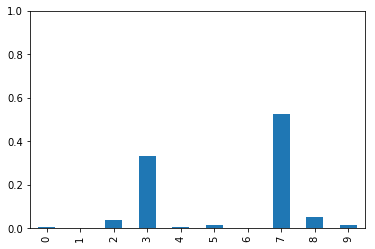

In [24]:
next(prediction)

# Extract Learned Parameters $[W_h$ $W_x$ $b]$ from RNN

In [25]:
W = {name: w for name, w in zip(['x', 'h', 'b'], model.layers[0].get_weights())}

{name: w.shape for name, w in W.items()}

{'b': (10,), 'h': (10, 10), 'x': (784, 10)}

# $W_x$

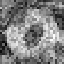

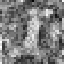

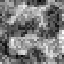

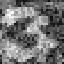

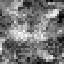

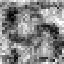

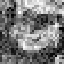

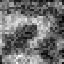

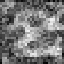

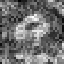

In [26]:
for i in range(10):
    w = W['x'][:, i].reshape(28, 28, 1)
    img = array_to_img(w).resize(size=[64, 64])
    display(img)

# $b$

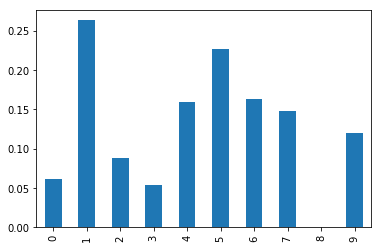

In [27]:
pd.Series(W['b'] - W['b'].min()).plot(kind='bar')

# $W_h$

In [28]:
import seaborn as sns

df = pd.DataFrame(W['h']).round(1)
df.style.background_gradient(cmap=sns.diverging_palette(250, 5, as_cmap=True))